# 数值分析 实验四
计63 陈晟祺 2016010981

## 上机题2

### 实验概要

本题将一个常微分方程的两点边值问题化为线性方程组，并要求用雅可比、高斯-赛德尔和逐次超松弛迭代法求线性方程组的解。在不同的参数下，求解同样的方程，并比较与精确解的误差。

## 实验过程

首先导入必要的库，并根据参数 $\varepsilon$ 和 $n$ 生成线性方程组的系数矩阵 $\mathbf{A}$ 和 $\mathbf{b}$。

需要注意的是，系数矩阵 $\mathbf{b}$ 不能全部初始化为 $ah^2$，其最后一项应该减去 $y_n(\varepsilon+h)=\varepsilon+h$。

In [1]:
import numpy as np
import matplotlib.pyplot as plt

eps = 1.
n = 100
h = 1. / n
a = 0.5

def generate_A():

    A = np.zeros((n - 1, n - 1))
    
    for i in range(n - 1):
        if i != 0:
            A[i][i-1] = eps
        A[i][i] = -(2 * eps + h)
        if i != n - 2:
            A[i][i+1] = eps + h
            
    return A

def generate_b():
    b = np.full((n - 1,), a * h * h)
    b[-1] -= 1 * (eps + h) # the last element need to be processed
    return b
    
A = generate_A()
b = generate_b()

计算方程的精确解，并用于计算误差：

In [2]:
def y_acc(x):
    return (1 - a) / (1 - np.exp(-1 / eps)) * (1 - np.exp(-x / eps)) + a * x

acc = [y_acc(x) for x in np.arange(h, 1, h)]

按照 Jacobi 迭代法写出代码。注意到 A 非常稀疏，因此不需要对每一行进行循环，只需要选择非零元素即可，因此每次迭代的代价只是 $O(n)$。下面的计算中，我们假设迭代法总是收敛的，不加以验证。

In [3]:
def Jacobi(A, b):
    x = np.ones_like(b)
    n = np.shape(b)[0]
    count = 0
    while True:
        y = np.copy(x)
        for i in range(n):
            x[i] = b[i]
            if i > 0:
                x[i] -= A[i][i - 1] * y[i - 1]
            if i < n - 1:
                x[i] -= A[i][i + 1] * y[i + 1]
            x[i] /= A[i][i]
        count += 1
        if np.array_equiv(np.around(x, decimals=4), np.around(y, decimals=4)): # equal with 4 digits
            print('Jacobi method stops after {} steps'.format(count))
            return x

In [4]:
jacob_sol = Jacobi(A, b)

Jacobi method stops after 6771 steps


Gauss-Seidel 迭代法：

In [5]:
def GS(A, b):
    n = np.shape(b)[0]
    x = np.ones_like(b)
    count = 0
    while True:
        x_orig = np.copy(x)
        for i in range(n):
            x[i] = b[i]
            if i > 0:
                x[i] -= A[i][i - 1] * x[i - 1]
            if i < n - 1:
                x[i] -= A[i][i + 1] * x[i + 1]
            x[i] /= A[i][i]
        count += 1
        if np.array_equal(np.around(x, decimals=4), np.around(x_orig, decimals=4)): # equal with 4 digits
            print('G-S method stops after {} steps'.format(count))
            return x
        del x_orig

In [6]:
GS_sol = GS(A, b)

G-S method stops after 3937 steps


SOR 迭代法：

In [7]:
def SOR(A, b, w):
    n = np.shape(b)[0]
    x = np.ones_like(b)
    count = 0
    while True:
        x_orig = np.copy(x)
        for i in range(n):
            x_gs = np.copy(b[i])
            if i > 0:
                x_gs -= A[i][i - 1] * x[i - 1]
            if i < n - 1:
                x_gs -= A[i][i + 1] * x[i + 1]
            x_gs /= A[i][i]
            x[i] = (1. - w) * x[i] + w * x_gs
        count += 1
        if np.array_equal(np.around(x, decimals=4), np.around(x_orig, decimals=4)): # equal with 4 digits
            print('SOR method stops after {} steps'.format(count))
            return x
        del x_orig

In [8]:
SOR_sol = SOR(A, b, 1.1)

SOR method stops after 3278 steps


观察到在此问题上 G-S 迭代法收敛所需的迭代步骤几乎只有 Jacobi 迭代法的一半，略少于 SOR 迭代法（如果选用别的 $\omega$，则 SOR 迭代法可能变得更慢收敛。

计算每种迭代法与解析解的误差，包括 $\infty$-范数和2-范数：

In [9]:
def calc_dist(res, orig):
    res = res.reshape(np.shape(orig))
    infty_norm = np.max(np.abs(res - orig))
    sec_norm = np.linalg.norm(res - orig)
    return infty_norm, sec_norm

print('Jacobi method:\tinfty norm {}, second norm {}'.format(*calc_dist(jacob_sol, acc)))
print('GS method:\tinfty norm {}, second norm {}'.format(*calc_dist(GS_sol, acc)))
print('SOR method:\tinfty norm {}, second norm {}'.format(*calc_dist(SOR_sol, acc)))

Jacobi method:	infty norm 0.017719708807683032, second norm 0.12471265293007758
GS method:	infty norm 0.009821996442479053, second norm 0.06902704596848402
SOR method:	infty norm 0.009091856070018278, second norm 0.06387801248061145


可以看到 Jacobi 迭代法的误差是最大的，而 SOR 方法的误差只有它的一半（2-范数意义下），也略小于 G-S 方法。下面将实际误差绘制为曲线，可以更直观地进行观察：

In [10]:
def plot_results(acc, jac, gs, sor):
    x = np.arange(h, 1, h)
    fig, ax = plt.subplots(figsize=(10,8))
    ax.set_xlabel('x')
    ax.set_ylabel('y error (logarithm)')
    ax.set_yscale('log')
    plt.plot(x, np.abs(jac - acc), label='Jacobi Method')
    plt.plot(x, np.abs(gs - acc), label='G-S Method')
    plt.plot(x, np.abs(sor - acc), label='SOR Method')
    plt.legend()
    plt.show()
    
    def f_to_str(f):
        return '{:.4f}'.format(f)
    
    with open('result_eps={}.txt'.format(eps), 'w') as f:
        f.write('x:\t')
        f.write('\t'.join(map(str, x)) + '\n')
        f.write('Accurate:\t')
        f.write('\t'.join(map(f_to_str, acc)) + '\n\n')
        f.write('Jacobi Result:\t')
        f.write('\t'.join(map(f_to_str, jac)) + '\n')
        f.write('Jacobi Error:\t')
        f.write('\t'.join(map(f_to_str, np.abs(acc - jac))) + '\n\n')
        f.write('G-S Result:\t')
        f.write('\t'.join(map(f_to_str, gs)) + '\n')
        f.write('G-S Error:\t')
        f.write('\t'.join(map(f_to_str, np.abs(acc - gs))) + '\n\n')
        f.write('SOR Result:\t')
        f.write('\t'.join(map(f_to_str, sor)) + '\n')
        f.write('SOR Error:\t')
        f.write('\t'.join(map(f_to_str, np.abs(acc - sor))) + '\n\n')

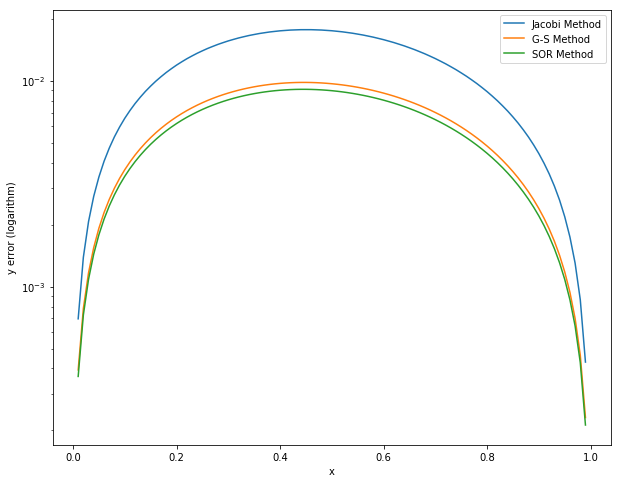

In [11]:
plot_results(acc, jacob_sol, GS_sol, SOR_sol)

可以看到迭代误差呈现中间大、两头小的趋势。得到的实际方程解被保存在对应的 txt 文件中。

下面使用不同的 $\varepsilon$ 进行方程求解，并观察它们的误差：

In [12]:
 def test_with_eps(e):
    print('Epsilon: {}'.format(e))
    global eps
    eps = e
    A = generate_A()
    b = generate_b()
    acc = [y_acc(x) for x in np.arange(h, 1, h)]
    jacob_sol = Jacobi(A, b)
    GS_sol = GS(A, b)
    SOR_sol = SOR(A, b, 1.1)
    print('Jacobi method:\tinfty norm {}, second norm {}'.format(*calc_dist(jacob_sol, acc)))
    print('GS method:\tinfty norm {}, second norm {}'.format(*calc_dist(GS_sol, acc)))
    print('SOR method:\tinfty norm {}, second norm {}'.format(*calc_dist(SOR_sol, acc)))
    plot_results(acc, jacob_sol, GS_sol, SOR_sol)

Epsilon: 0.1
Jacobi method stops after 2933 steps
G-S method stops after 1739 steps
SOR method stops after 1442 steps
Jacobi method:	infty norm 0.00368474361040938, second norm 0.016689298515842808
GS method:	infty norm 0.006325079203691519, second norm 0.02430851894044931
SOR method:	infty norm 0.006459733891286623, second norm 0.02503635831126469


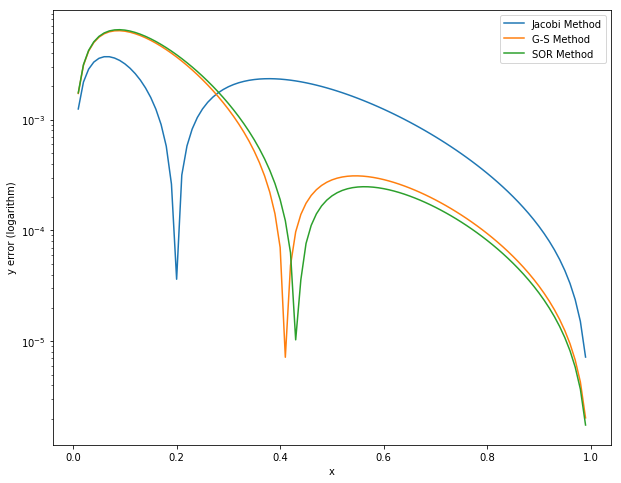

In [13]:
test_with_eps(0.1)

可以看到，$\varepsilon=0.1$ 时，Jacobi 迭代法收敛依旧较慢，但是在 $x$ 较小时误差较小。

Epsilon: 0.01
Jacobi method stops after 408 steps
G-S method stops after 262 steps
SOR method stops after 217 steps
Jacobi method:	infty norm 0.06572844579586828, second norm 0.09788609004952256
GS method:	infty norm 0.06593533310105104, second norm 0.09848322850554118
SOR method:	infty norm 0.06587101387091926, second norm 0.0983230766666076


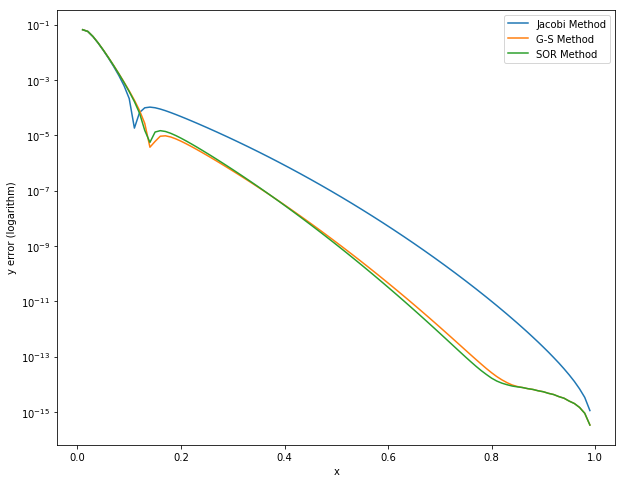

In [14]:
test_with_eps(0.01)

在 $\varepsilon=0.01$ 时，三种迭代法的误差相差不大，并且随 $x$ 增大而减小，收敛速度明显变得更快了。

Epsilon: 0.0001
Jacobi method stops after 108 steps
G-S method stops after 104 steps
SOR method stops after 138 steps
Jacobi method:	infty norm 0.00492262879991856, second norm 0.004922798548847889
GS method:	infty norm 0.0049463133782503554, second norm 0.004946549778426203
SOR method:	infty norm 0.004950372651881363, second norm 0.004950615561139347


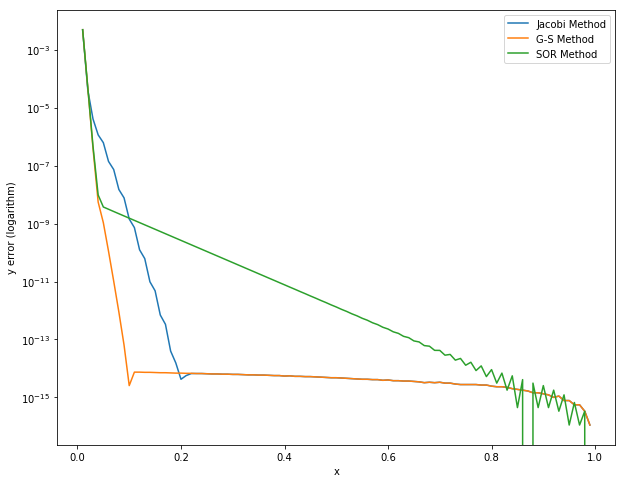

In [15]:
test_with_eps(0.0001)

当 $\varepsilon=0.0001$ 时，三种方法的收敛速度和误差都相差不大，都很快收敛了。

从上面的实验中，可以观察到，随着 $\varepsilon$ 的减小，三种迭代方法的收敛速度都变快了，并且整体误差也逐渐减小。这是因为，当 $\varepsilon$ 越小，微分方程的解就越线性，从而差分方法能够得到更精确的解，也能更快收敛；而当其较大时，差分本身会带来一定的误差，并且收敛也比较慢。特别地，当 $\varepsilon$ 较小时，函数在靠近 $0$ 点处的斜率非常大，变化陡峭，因此在附近的误差相对其他位置会变得很大，这从上面的误差曲线中可以很明显的看出来。

## 实验结论

本实验中，我实现了线性方程组的 Jacobi、G-S 和 SOR 迭代解法，并对于要求解的稀疏矩阵进行了针对性的复杂度优化。可以看到，对于不同的系数矩阵，这三种迭代法有不同的收敛速度和误差，其中 Jacobi 迭代法往往劣于 G-S 和 SOR 方法。